In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import pairwise_distances, matthews_corrcoef  # Jaccard, Phi 
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
#!uv pip install scikit-learn matplotlib seaborn statsmodels

In [3]:
best_refs = pd.read_csv('scaffold_references.csv')
best_refs['Scaffold assembly'] = best_refs['Query assembly'] + '_scaffold'

In [5]:
sra_calls = pd.read_csv('SRAs/replicon_annotations_1000bp.csv')
sra_calls_all = pd.read_csv('SRAs/replicon_annotations.csv')
scaf_calls = pd.read_csv('scaffolded_asms/replicon_annotations_1000bp.csv')
scaf_calls_all = pd.read_csv('scaffolded_asms/replicon_annotations.csv')
# lra_calls = pd.read_csv('LRAs/replicon_annotations_1000bp.csv')
lra_calls = pd.read_csv('../genotyping/replicons/calls_v10/best_hits_1000bp_v11.csv')
# lra_calls_all = pd.read_csv('LRAs/replicon_annotations.csv')
lra_calls_all = pd.read_csv('../genotyping/replicons/calls_v10/calls/summary_all_calls.tsv', sep='\t')

sra_replicons = sra_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()
scaf_replicons = scaf_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()
lra_replicons = lra_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()

replicon_matches = \
    pd.merge(
        pd.merge(
            pd.merge(best_refs, lra_replicons, left_on='Ref assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'LRA replicons', 'assembly_id':'LRA assembly'}),
            sra_replicons, left_on='Query assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'SRA replicons', 'assembly_id':'SRA assembly'}),
        scaf_replicons, left_on='Scaffold assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'Scaffold replicons'}).drop(columns='assembly_id')
replicon_matches = replicon_matches[['SRA assembly', 'Scaffold assembly', 'LRA assembly', 'ANI (mean)', 'SRA replicons', 'Scaffold replicons', 'LRA replicons']]
replicon_matches = replicon_matches.dropna().reset_index(drop=True)
replicon_matches

,SRA assembly,Scaffold assembly,LRA assembly,ANI (mean),SRA replicons,Scaffold replicons,LRA replicons
0,ESI26,ESI26_scaffold,ESI26H,98.159574,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-3, c..."
1,ESI284,ESI284_scaffold,URI56H,98.148889,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-10, cp32-11, cp32-3, c..."
2,ESI285,ESI285_scaffold,URI56H,98.143333,"[chromosome, cp26, cp32-1, cp32-10, cp32-12, c...","[chromosome, cp26, cp32-1, cp32-10, cp32-12, c...","[chromosome, cp26, cp32-10, cp32-11, cp32-3, c..."
3,ESI286,ESI286_scaffold,URI56H,98.301111,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ...","[chromosome, cp26, cp32-10, cp32-11, cp32-3, c..."
4,ESI287,ESI287_scaffold,UCT113H,98.422703,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-11, cp32-12, cp32-2, c..."
...,...,...,...,...,...,...,...
294,UWI279,UWI279_scaffold,URI33H,99.110500,"[chromosome, cp26, cp32-1+5, cp32-10, cp32-11,...","[chromosome, cp26, cp32-1+5, cp32-10, cp32-11,...","[chromosome, cp26, cp32-1+5, cp32-11, cp32-6, ..."
295,UWI280,UWI280_scaffold,UWI247P,99.573585,"[chromosome, cp26, cp32-1, cp32-11, cp32-12, c...","[chromosome, cp26, cp32-1, cp32-11, cp32-12, c...","[chromosome, cp26, cp32-1, cp32-11, cp32-2, cp..."
296,UWI281,UWI281_scaffold,GCF_003367295.1_ASM336729v1_genomic,99.687537,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-4, c..."
297,UWI282,UWI282_scaffold,UWI283P,99.221563,"[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-10, ...","[chromosome, cp26, cp32-1, cp32-1+5, cp32-12, ..."


In [6]:
all_reps = pd.DataFrame(pd.concat([sra_calls['plasmid_name'], scaf_calls['plasmid_name'], lra_calls['plasmid_name']])).drop_duplicates().reset_index(drop=True)
all_reps = all_reps.rename(columns={'plasmid_name':'replicon'})
all_reps['Count (SRA, Scaf, LRA)'] = 0
all_reps['Count (SRA, Scaf)'] = 0
all_reps['Count (SRA, LRA)'] = 0
all_reps['Count (Scaf, LRA)'] = 0
all_reps['Count (SRA)'] = 0
all_reps['Count (Scaf)'] = 0
all_reps['Count (LRA)'] = 0
for i, row in all_reps.iterrows():
    replicon = row['replicon']
    sra_idxs = replicon_matches[replicon_matches['SRA replicons'].apply(lambda x: replicon in x)].index.tolist()
    scaf_idxs = replicon_matches[replicon_matches['Scaffold replicons'].apply(lambda x: replicon in x)].index.tolist()
    lra_idxs = replicon_matches[replicon_matches['LRA replicons'].apply(lambda x: replicon in x)].index.tolist()

    col_idx = all_reps.columns.tolist().index('Count (SRA, Scaf, LRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(scaf_idxs)).intersection(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (SRA, Scaf)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(scaf_idxs)) - set(lra_idxs))

    col_idx = all_reps.columns.tolist().index('Count (SRA, LRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(lra_idxs)) - set(scaf_idxs))

    col_idx = all_reps.columns.tolist().index('Count (Scaf, LRA)')
    all_reps.iloc[i, col_idx] += len(set(scaf_idxs).intersection(set(lra_idxs)) - set(sra_idxs))

    col_idx = all_reps.columns.tolist().index('Count (SRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs) - set(scaf_idxs).union(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (Scaf)')
    all_reps.iloc[i, col_idx] += len(set(scaf_idxs) - set(sra_idxs).union(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (LRA)')
    all_reps.iloc[i, col_idx] += len(set(lra_idxs) - set(sra_idxs).union(set(scaf_idxs)))
    
all_reps['Total'] = all_reps.apply(lambda x: x[[col for col in all_reps.columns if col!='replicon']].sum(), axis=1)
all_reps = all_reps.sort_values(by=['Count (SRA, Scaf, LRA)', 'replicon'], ascending=[False, True]).reset_index(drop=True)
all_reps

,replicon,"Count (SRA, Scaf, LRA)","Count (SRA, Scaf)","Count (SRA, LRA)","Count (Scaf, LRA)",Count (SRA),Count (Scaf),Count (LRA),Total
0,chromosome,299,0,0,0,0,0,0,299
1,cp26,299,0,0,0,0,0,0,299
2,lp54,295,0,0,0,0,0,4,299
3,lp17,285,2,3,0,1,0,8,299
4,lp36,275,10,10,0,3,0,1,299
5,lp28-3,252,15,17,1,0,0,5,290
6,lp28-4,241,13,10,1,31,0,2,298
7,cp32-7,227,52,5,0,4,0,7,295
8,lp38,202,33,2,7,2,0,31,277
9,cp32-11,193,57,3,1,14,1,21,290


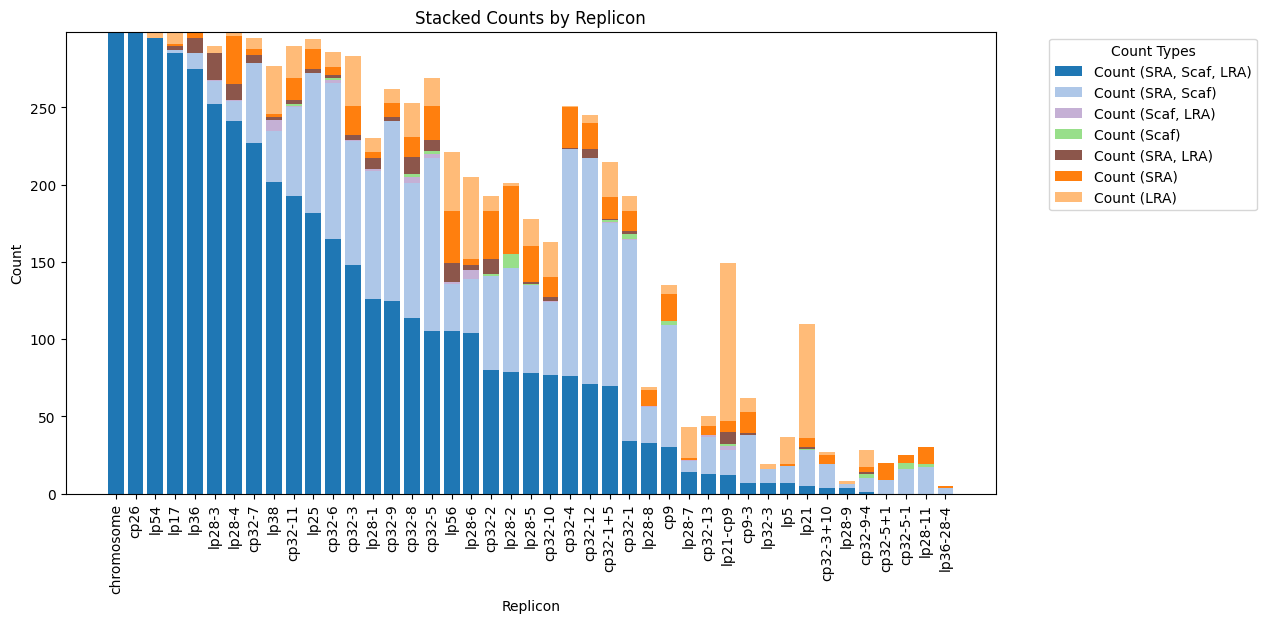

In [7]:
all_reps = all_reps.sort_values(by=['Count (SRA, Scaf, LRA)', 'replicon'], ascending=[False, True]).reset_index(drop=True)

count_columns = [
    'Count (SRA, Scaf, LRA)',
    'Count (SRA, Scaf)',
    'Count (Scaf, LRA)',
    'Count (Scaf)',
    'Count (SRA, LRA)',
    'Count (SRA)',
    'Count (LRA)'
]
colors = {
    'Count (SRA, Scaf, LRA)': '#1f77b4',  # muted blue
    'Count (SRA, Scaf)': '#aec7e8',       # light blue
    'Count (Scaf, LRA)': '#c5b0d5',       # lavender
    'Count (Scaf)': '#98df8a',            # light green
    'Count (SRA, LRA)': '#8c564b',        # brown
    'Count (SRA)': '#ff7f0e',             # orange
    'Count (LRA)': '#ffbb78'              # light tan/orange
}

fig, ax = plt.subplots(figsize=(12, 6))

bottom = pd.Series([0]*len(all_reps), index=all_reps.index)
x = all_reps['replicon']

for col in count_columns:
    ax.bar(x, all_reps[col], bottom=bottom, label=col, color=colors[col])
    bottom += all_reps[col]

# Beautify plot
ax.set_xlabel('Replicon')
ax.set_ylabel('Count')
ax.set_title('Stacked Counts by Replicon')
ax.legend(title='Count Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90);

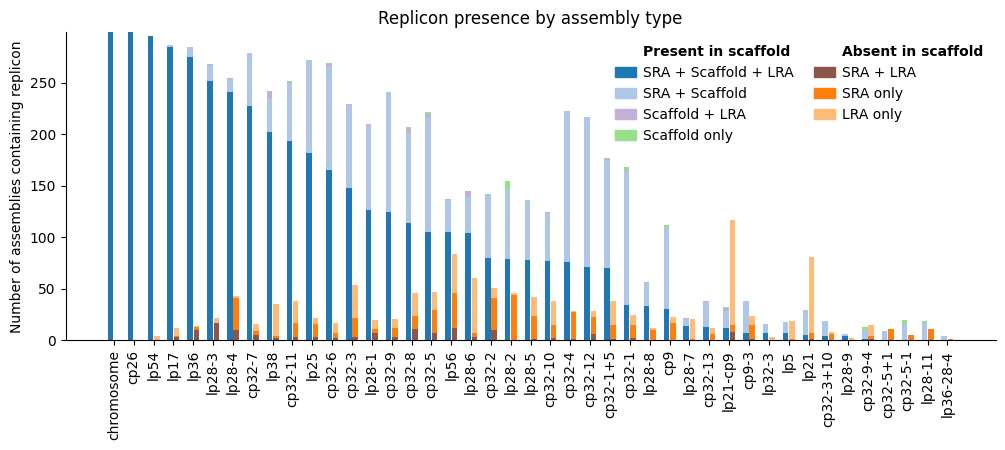

In [8]:
def plot_minibars(ax, replicon, colors, width=0.8):
    # Get the index position of the replicon
    x_pos = all_reps[all_reps['replicon'] == replicon].index[0]

    # Calculate adjusted bar width
    scale_factor = 0.1
    bar_width = (scale_factor * (width - 1) + width) / 2

    # Compute positions for left and right mini-bars
    x_left = x_pos - width / 2 + bar_width / 2
    x_right = x_pos + width / 2 - bar_width / 2

    # Data columns for each mini-bar
    left_columns = ['Count (SRA, Scaf, LRA)', 'Count (SRA, Scaf)', 'Count (Scaf, LRA)', 'Count (Scaf)']
    right_columns = ['Count (SRA, LRA)', 'Count (SRA)', 'Count (LRA)']

    # Get the row of interest
    row = all_reps[all_reps['replicon'] == replicon].iloc[0]

    # Plot left mini-bar
    bottom = 0
    for i, col in enumerate(left_columns):
        height = row[col]
        ax.bar(x_left, height, width=bar_width, bottom=bottom, color=colors[0][i])
        bottom += height

    # Plot right mini-bar
    bottom = 0
    for i, col in enumerate(right_columns):
        height = row[col]
        ax.bar(x_right, height, width=bar_width, bottom=bottom, color=colors[1][i])
        bottom += height

def draw_legend(ax, colors):
    left_labels = ['SRA + Scaffold + LRA', 'SRA + Scaffold', 'Scaffold + LRA', 'Scaffold only']
    right_labels = ['SRA + LRA', 'SRA only', 'LRA only']
    left_colors = colors[0]
    right_colors = colors[1]
    left_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(left_colors, left_labels)]
    right_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(right_colors, right_labels)]
    
    header_left = mpatches.Patch(color='none', label='Present in scaffold')
    header_right = mpatches.Patch(color='none', label='Absent in scaffold')
    legend_patches = [header_left] + left_patches + [header_right] + right_patches

    legend = ax.legend(
        handles=legend_patches,
        ncol=2,
        loc='upper right',
        # bbox_to_anchor=(1.02, 1),
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        columnspacing=1.5
    )
    legend.get_texts()[0].set_weight('bold')
    legend.get_texts()[5].set_weight('bold')  # index 5 because 1 header + 4 items


all_reps = all_reps.sort_values(by=['Count (SRA, Scaf, LRA)', 'replicon'], ascending=[False, True]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))

colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # for left mini-bars
    ['#8c564b', '#ff7f0e', '#ffbb78']              # for right mini-bars
]

for replicon in all_reps['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors)

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90)
ax.set_ylabel("Count")
ax.spines[['top', 'right']].set_visible(False);

ax.set_title("Replicon presence by assembly type");
ax.set_ylabel('Number of assemblies containing replicon');

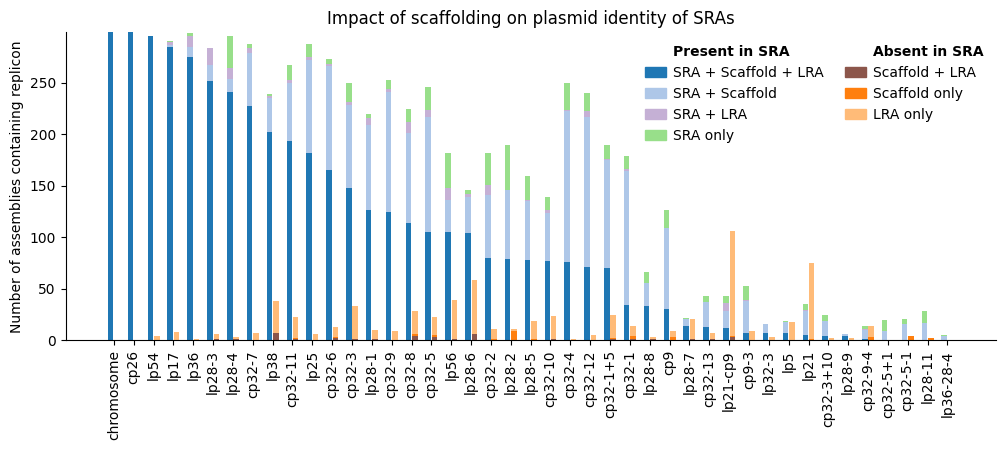

In [9]:
def plot_minibars(ax, replicon, colors, width=0.8):
    x_pos = all_reps[all_reps['replicon'] == replicon].index[0]
    scale_factor = 0.1
    bar_width = (scale_factor * (width - 1) + width) / 2
    x_left = x_pos - width / 2 + bar_width / 2
    x_right = x_pos + width / 2 - bar_width / 2

    # Now based on SRA presence
    left_columns = ['Count (SRA, Scaf, LRA)', 'Count (SRA, Scaf)', 'Count (SRA, LRA)', 'Count (SRA)']
    right_columns = ['Count (Scaf, LRA)', 'Count (Scaf)', 'Count (LRA)']

    row = all_reps[all_reps['replicon'] == replicon].iloc[0]

    bottom = 0
    for i, col in enumerate(left_columns):
        height = row[col]
        ax.bar(x_left, height, width=bar_width, bottom=bottom, color=colors[0][i])
        bottom += height

    bottom = 0
    for i, col in enumerate(right_columns):
        height = row[col]
        ax.bar(x_right, height, width=bar_width, bottom=bottom, color=colors[1][i])
        bottom += height


def draw_legend(ax, colors):
    left_labels = ['SRA + Scaffold + LRA', 'SRA + Scaffold', 'SRA + LRA', 'SRA only']
    right_labels = ['Scaffold + LRA', 'Scaffold only', 'LRA only']

    left_colors = colors[0]
    right_colors = colors[1]

    left_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(left_colors, left_labels)]
    right_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(right_colors, right_labels)]

    header_left = mpatches.Patch(color='none', label='Present in SRA')
    header_right = mpatches.Patch(color='none', label='Absent in SRA')
    legend_patches = [header_left] + left_patches + [header_right] + right_patches

    legend = ax.legend(
        handles=legend_patches,
        ncol=2,
        loc='upper right',
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        columnspacing=1.5
    )
    legend.get_texts()[0].set_weight('bold')
    legend.get_texts()[5].set_weight('bold')


# Sorting still optional; use whatever order you'd like
all_reps = all_reps.sort_values(by=['Count (SRA, Scaf, LRA)', 'replicon'], ascending=[False, True]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))

colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # SRA-present
    ['#8c564b', '#ff7f0e', '#ffbb78']              # SRA-absent (brown and tan)
]

for replicon in all_reps['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors)

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90)
ax.set_ylabel("Count")
ax.spines[['top', 'right']].set_visible(False)

ax.set_title("Impact of scaffolding on plasmid identity of SRAs")
ax.set_ylabel('Number of assemblies containing replicon');

In [10]:
print(all_reps.sort_values(by='Count (SRA)', ascending=False).head(10)[['replicon', 'Count (SRA)']].reset_index())
print()
print(all_reps.sort_values(by='Count (SRA, LRA)', ascending=False).head(10)[['replicon', 'Count (SRA, LRA)']].reset_index())
print()
print(all_reps.sort_values(by='Count (Scaf, LRA)', ascending=False).head(10)[['replicon', 'Count (Scaf, LRA)']].reset_index())
print()
print(all_reps.sort_values(by='Count (Scaf)', ascending=False).head(10)[['replicon', 'Count (Scaf)']].reset_index())
print()

   index replicon  Count (SRA)
0     20   lp28-2           44
1     17     lp56           34
2      6   lp28-4           31
3     19   cp32-2           31
4     23   cp32-4           26
5     21   lp28-5           23
6     16   cp32-5           22
7     12   cp32-3           19
8     24  cp32-12           17
9     28      cp9           17

   index  replicon  Count (SRA, LRA)
0      5    lp28-3                17
1     17      lp56                12
2     15    cp32-8                11
3      4      lp36                10
4     19    cp32-2                10
5      6    lp28-4                10
6     31  lp21-cp9                 8
7     13    lp28-1                 7
8     16    cp32-5                 7
9     24   cp32-12                 6

   index  replicon  Count (Scaf, LRA)
0      8      lp38                  7
1     18    lp28-6                  6
2     15    cp32-8                  4
3     31  lp21-cp9                  3
4     16    cp32-5                  3
5     11    cp32-6    

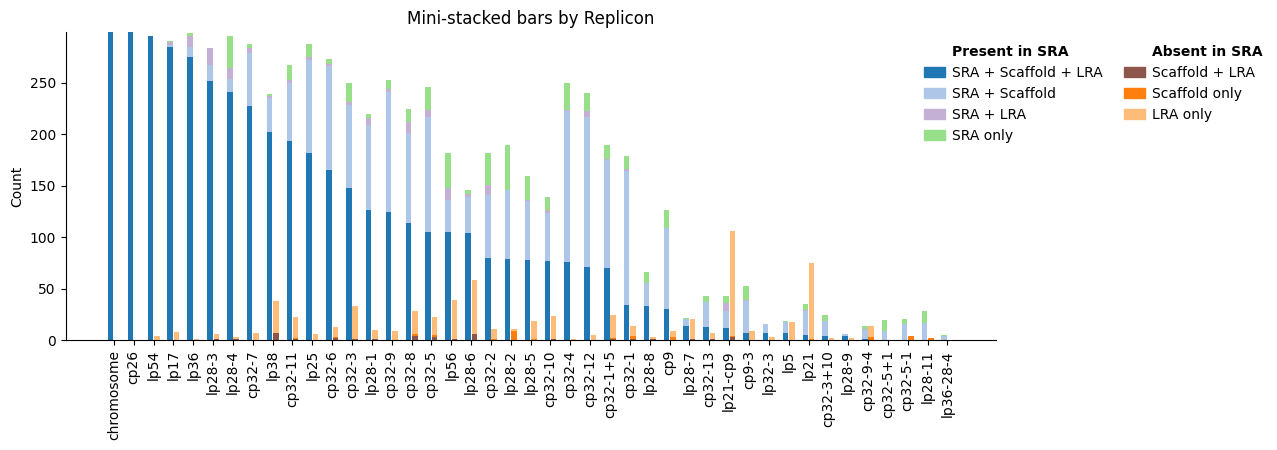

In [11]:
def replicon_sort_key(replicon):
    if replicon == 'chromosome':
        return (0, 0, 0) 
    match = re.match(r'^(lp|cp)(\d+)((?:[-+]\d+)*)$', replicon)
    if not match:
        return (3, 0, 0)  # fallback for unmatched patterns

    prefix, main_num, suffix = match.groups()
    prefix_order = 1 if prefix == 'lp' else 2
    main_num = int(main_num)
    suffix_numbers = list(map(int, re.findall(r'[-+](\d+)', suffix))) if suffix else []
    if not suffix_numbers:
        suffix_numbers = [0]
        
    return (prefix_order, main_num, *suffix_numbers)

# Sort the dataframe
replicons_ordered = all_reps[['replicon']].copy()
replicons_ordered['sort_key'] = replicons_ordered['replicon'].apply(replicon_sort_key)
replicons_ordered = replicons_ordered.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))

colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # for left mini-bars
    ['#8c564b', '#ff7f0e', '#ffbb78']              # for right mini-bars
]

for replicon in replicons_ordered['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors)
ax.get_legend().set(bbox_to_anchor=(1.3, 1))

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90)
ax.set_ylabel("Count")
ax.spines[['top', 'right']].set_visible(False);

ax.set_title("Mini-stacked bars by Replicon");

In [12]:
all_reps

,replicon,"Count (SRA, Scaf, LRA)","Count (SRA, Scaf)","Count (SRA, LRA)","Count (Scaf, LRA)",Count (SRA),Count (Scaf),Count (LRA),Total
0,chromosome,299,0,0,0,0,0,0,299
1,cp26,299,0,0,0,0,0,0,299
2,lp54,295,0,0,0,0,0,4,299
3,lp17,285,2,3,0,1,0,8,299
4,lp36,275,10,10,0,3,0,1,299
5,lp28-3,252,15,17,1,0,0,5,290
6,lp28-4,241,13,10,1,31,0,2,298
7,cp32-7,227,52,5,0,4,0,7,295
8,lp38,202,33,2,7,2,0,31,277
9,cp32-11,193,57,3,1,14,1,21,290


In [16]:
dissemination_df = pd.merge(
    pd.read_csv('LymeSeq_SampleTrack - Renaming Scheme Table for Jupyter.2023-02-14.csv'),
    replicon_matches, right_on='SRA assembly', left_on='Rename_A', how='inner')
dissemination_df.head()

,Rename_A,Original_Name,Origin,Location,OspC_Type,RST_Type,OspC_Allele,MLST,Disseminated,BC + (Y/N),...,Spades,BBMerge,sp_identification,SRA assembly,Scaffold assembly,LRA assembly,ANI (mean),SRA replicons,Scaffold replicons,LRA replicons
0,UMA1,N2,US,Nantucket,K,2.0,NaN,3,L,ND,...,y,y,y,UMA1,UMA1_scaffold,GCF_040790795.1_ASM4079079v1_genomic,99.819070,"[chromosome, cp26, cp32-1+5, cp32-11, cp32-12,...","[chromosome, cp26, cp32-11, cp32-12, cp32-2, c...","[chromosome, cp26, cp32-11, cp32-2, cp32-3, cp..."
1,UMA2,N4,US,Nantucket,F,2.0,NaN,8,L,ND,...,y,y,y,UMA2,UMA2_scaffold,UNY990P,99.246471,"[chromosome, cp26, cp32-1, cp32-10, cp32-11, c...","[chromosome, cp26, cp32-1, cp32-10, cp32-11, c...","[chromosome, cp26, cp32-11, cp32-6, cp32-8, cp..."
2,UMA3,N7,US,Nantucket,K,2.0,NaN,3,L,ND,...,NaN,NaN,NaN,UMA3,UMA3_scaffold,URI56H,99.176923,"[chromosome, cp26, cp32-1+5, cp32-11, cp32-12,...","[chromosome, cp26, cp32-1+5, cp32-11, cp32-12,...","[chromosome, cp26, cp32-10, cp32-11, cp32-3, c..."
3,UMA4,N9,US,Nantucket,K,2.0,NaN,3,L,ND,...,y,y,y,UMA4,UMA4_scaffold,GCF_040790795.1_ASM4079079v1_genomic,99.787805,"[chromosome, cp26, cp32-1+5, cp32-11, cp32-12,...","[chromosome, cp26, cp32-1+5, cp32-11, cp32-12,...","[chromosome, cp26, cp32-11, cp32-2, cp32-3, cp..."
4,UMA5,N11,US,Nantucket,N,2.0,NaN,36,L,ND,...,y,y,y,UMA5,UMA5_scaffold,URI33H,99.109362,"[chromosome, cp26, cp32-1, cp32-11, cp32-12, c...","[chromosome, cp26, cp32-11, cp32-12, cp32-2, c...","[chromosome, cp26, cp32-1+5, cp32-11, cp32-6, ..."


In [17]:
def replist_to_array(replicon_list, key):
    return np.array([int(ki in replicon_list) for ki in key])

def replicon_sort_key(replicon):
    if replicon == 'chromosome':
        return (0, 0, 0) 
    match = re.match(r'^(lp|cp)(\d+)((?:[-+]\d+)*)$', replicon)
    if not match:
        return (3, 0, 0)  # fallback for unmatched patterns

    prefix, main_num, suffix = match.groups()
    prefix_order = 1 if prefix == 'lp' else 2
    main_num = int(main_num)
    suffix_numbers = list(map(int, re.findall(r'[-+](\d+)', suffix))) if suffix else []
    if not suffix_numbers:
        suffix_numbers = [0]
        
    return (prefix_order, main_num, *suffix_numbers)

# Get list of all replicons
replicons_ordered = all_reps[['replicon']].copy()
replicons_ordered['sort_key'] = replicons_ordered['replicon'].apply(replicon_sort_key)
replicons_ordered = replicons_ordered.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

## Get X and Y for whole dataset
dissemination_encoder = LabelEncoder()
replicon_key = replicons_ordered['replicon'].tolist()
# X_SRA = np.stack(dissemination_df['SRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
X_scaf_all = np.stack(dissemination_df['Scaffold replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
# X_LRA = np.stack(dissemination_df['LRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
Y_all = dissemination_encoder.fit_transform(dissemination_df['Disseminated'].tolist())

## Take cleaned data
n = 100     # number of samples to take from each dissemination group
regression_df = dissemination_df[dissemination_df['Disseminated']!='ND'].groupby('Disseminated').sample(n)   # don't sample from ND
X_SRA = np.stack(regression_df['SRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
X_scaf = np.stack(regression_df['Scaffold replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
X_LRA = np.stack(regression_df['LRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
Y = dissemination_encoder.fit_transform(regression_df['Disseminated'].tolist())

# Do PCA on cleaned data
n_pc_dims = len(replicons_ordered)
pca_transformers = []
X_PCAs = []
for x in [X_SRA, X_scaf, X_LRA]:
    pca = PCA(n_components=n_pc_dims)
    x = pca.fit_transform(x)
    pca_transformers.append(pca)
    X_PCAs.append(x)
X_SRA_PCA, X_scaf_PCA, X_LRA_PCA = X_PCAs

/tmp/ipykernel_53730/1087028695.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(dissemination_long);
/tmp/ipykernel_53730/1087028695.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(dissemination_long);
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/mf01

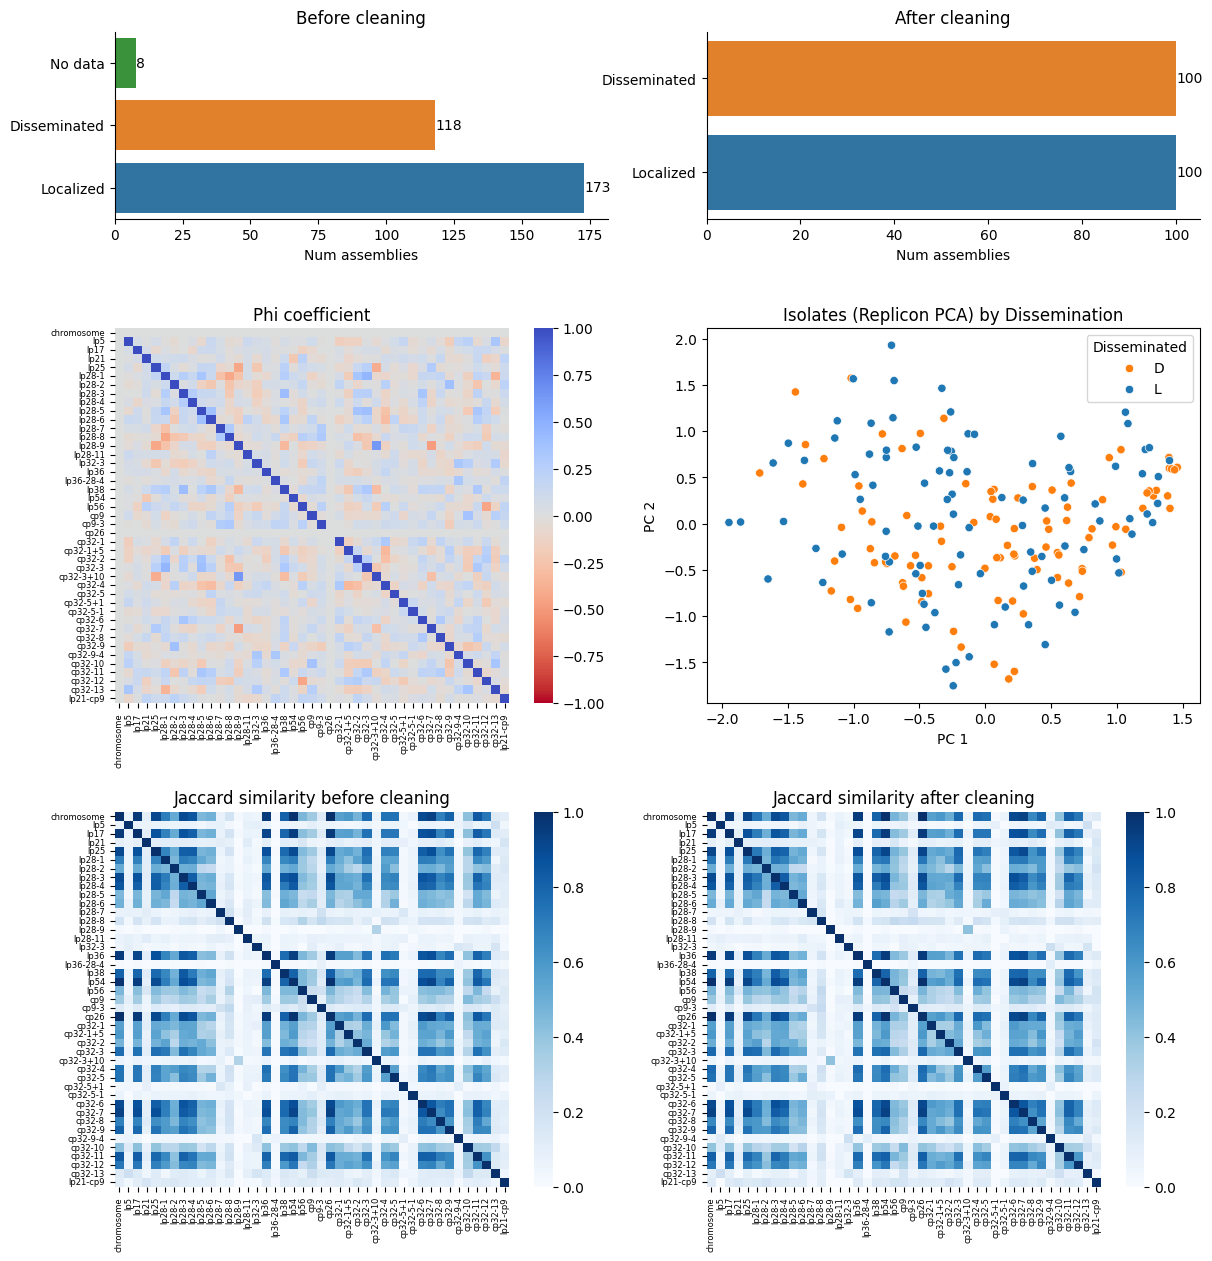

In [18]:
dis_palette = {'D':'tab:orange',
               'L':'tab:blue',
               'ND':'tab:green'}

fig, axes = plt.subplots(3, 2, figsize=(14,15), gridspec_kw={'height_ratios':[1, 2, 2]})
fig.subplots_adjust(wspace=0.2, hspace=0.35);

ax = axes[0, 0]
ax.set_title('Before cleaning');
d_shortlong = [('ND', 'No data'), ('D', 'Disseminated'), ('L', 'Localized')]
dissemination_short = [t[0] for t in d_shortlong]
dissemination_long = [t[1] for t in d_shortlong]
sns.countplot(y='Disseminated',
              data=dissemination_df,
              hue='Disseminated',
              order=dissemination_short,
              palette=dis_palette,
              ax=ax);

ax.set_yticklabels(dissemination_long);
ax.set_ylabel('');
ax.set_xlabel('Num assemblies');
for i, k in enumerate(dissemination_short):
    count = (dissemination_df['Disseminated'] == k).sum()
    ax.text(count, i, str(count), ha='left', va='center');
ax.spines[['top', 'right']].set_visible(False);

ax = axes[0, 1]
ax.set_title('After cleaning');
d_shortlong = [('D', 'Disseminated'), ('L', 'Localized')]
dissemination_short = [t[0] for t in d_shortlong]
dissemination_long = [t[1] for t in d_shortlong]
sns.countplot(y='Disseminated',
              data=regression_df,
              hue='Disseminated',
              order=dissemination_short,
              palette=dis_palette,
              ax=ax);

ax.set_yticklabels(dissemination_long);
ax.set_ylabel('');
ax.set_xlabel('Num assemblies');
for i, k in enumerate(dissemination_short):
    count = (regression_df['Disseminated'] == k).sum()
    ax.text(count, i, str(count), ha='left', va='center');
ax.spines[['top', 'right']].set_visible(False);



ax = axes[1, 0]
ax.set_title('Phi coefficient');
phi = np.array([[matthews_corrcoef(A, B) for A in X_scaf.transpose(1, 0)] for B in X_scaf.transpose(1, 0)]).squeeze()
vabs = max([abs(phi.min()), abs(phi.max())])
sns.heatmap(phi,
            vmin = -vabs, vmax=vabs,
            cmap='coolwarm_r',
            ax=ax)
ax.set_xticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_xticklabels(replicon_key, rotation=90, fontsize=6);
ax.set_yticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_yticklabels(replicon_key, rotation=0, fontsize=6);

ax = axes[1, 1]
ax.set_title('Isolates (Replicon PCA) by Dissemination');
plot_df = regression_df.copy()
plot_df[['PC 1', 'PC 2']] = X_scaf_PCA[:, :2]
sns.scatterplot(x='PC 1',
                y='PC 2',
                hue='Disseminated',
                data=plot_df,
                palette=dis_palette,
                ax=ax);


ax = axes[2, 0]
ax.set_title('Jaccard similarity before cleaning');
jaccard_dist = pairwise_distances(X_scaf_all.transpose(1, 0), metric='jaccard')
jaccard_sim = 1 - jaccard_dist  # Similarity = 1 - distance
sns.heatmap(jaccard_sim,
            vmin = 0, vmax=1,
            cmap='Blues',
            ax=ax)
ax.set_xticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_xticklabels(replicon_key, rotation=90, fontsize=6);
ax.set_yticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_yticklabels(replicon_key, rotation=0, fontsize=6);

ax = axes[2, 1]
ax.set_title('Jaccard similarity after cleaning');
jaccard_dist = pairwise_distances(X_scaf.transpose(1, 0), metric='jaccard')
jaccard_sim = 1 - jaccard_dist  # Similarity = 1 - distance
sns.heatmap(jaccard_sim,
            vmin = 0, vmax=1,
            cmap='Blues',
            ax=ax)
ax.set_xticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_xticklabels(replicon_key, rotation=90, fontsize=6);
ax.set_yticks([i+0.5 for i in range(len(replicon_key))]);
ax.set_yticklabels(replicon_key, rotation=0, fontsize=6);

Left side - raw data\
Right side - corrected data (subsample to even balanced outcome and perform PCA)\
\
Top left - Distribution of outcomes shows slight skew toward localized infection with some missing data\
Top right - Corrected data has 200 samples, evenly split between localized and disseminated outcomes\
Middle left - Phi coefficient, binary corrolary to Pearson correlation coefficient, shows meager correlation\
Middle right - First two principal components do not easily separate data out into disseminated / localized\
Bottom left - Jaccard similarity (more accurate measure of co-occurance than Phi for presence / absence data) shows structure in input data\
Bottom right - subsampling does not seem to impact the underlying structure of the input data\

In [19]:
def base_layer(X, Y, **kwargs):
    penalty=kwargs.pop('penalty', 'l2')
    solver=kwargs.pop('solver', 'lbfgs')
    max_iter=kwargs.pop('max_iter', 1000)
    class_weight=kwargs.pop('class_weight', 'balanced')
    clf = LogisticRegression(penalty=penalty,
                             solver=solver,
                             max_iter=max_iter,
                             class_weight=class_weight)
    clf.fit(X, Y)
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    betas = clf.coef_.flatten()
    odds_ratios = np.exp(betas)

    cm = confusion_matrix(Y, (y_pred > 0.5).astype(int))

    metrics = {
        'accuracy': accuracy_score(Y, y_pred),
        'precision': precision_score(Y, y_pred),
        'recall': recall_score(Y, y_pred),
        'f1': f1_score(Y, y_pred),
        'auc': roc_auc_score(Y, y_prob)
    }

    return metrics, odds_ratios, cm, betas, clf

def bootstrap_layer(X, Y, fit_model_func, **kwargs):
    # Retain the same original kwargs for each iteration
    bootstrap_iter = kwargs.pop('bootstrap_iter', 200)
    bootstrap_subsample = kwargs.pop('bootstrap_subsample', 80)
    original_args = kwargs
    metrics_all = defaultdict(list)
    betas_all = []
    odds_ratios_all = []
    cm_all = []
    models_all = []
    for _ in range(bootstrap_iter):
        kwargs = original_args
        kwargs['random_state'] = np.random.randint(10*bootstrap_iter)
        metrics, odds_ratios, cm, betas, model = subsample_layer(X, Y, fit_model_func, bootstrap_subsample, **kwargs)
        for k, v in metrics.items():
            metrics_all[k].append(v)
        betas_all.append(betas)
        odds_ratios_all.append(odds_ratios)
        cm_all.append(cm)
        models_all.append(model)
    odds_ratios_all = np.stack(odds_ratios_all)
    cm_all = np.stack(cm_all)
    betas_all = np.stack(betas_all)
    return metrics_all, odds_ratios_all, cm_all, betas_all, models_all

def subsample_layer(X, Y, fit_model_func, subsample_n, **kwargs):
    random_state = kwargs.pop('random_state', 42)
    np.random.seed(random_state)

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(X)
    df['Y'] = Y
    # Subsample each class
    subsample = df.groupby('Y').sample(subsample_n, replace=False, random_state=random_state)

    X_sub = subsample.drop(columns='Y').values
    Y_sub = subsample['Y'].values

    metrics, odds_ratios, cm, betas, clf = fit_model_func(X_sub, Y_sub, **kwargs)
    return metrics, odds_ratios, cm, betas, clf

def scaling_layer(X, Y, fit_model_func, **kwargs):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    metrics, odds_ratios_scaled, cm, betas, model = fit_model_func(X_scaled, Y, **kwargs)

    # Inverse transform odds ratios to original space
    beta_scaled = betas
    beta_original = beta_scaled / scaler.scale_
    odds_ratios_original = np.exp(beta_original)

    return metrics, odds_ratios_original, cm, beta_original, model

def pca_layer(X, Y, fit_model_func, **kwargs):
    # Apply PCA
    n_components = kwargs.pop('n_components', X.shape[1])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # Call fit_model recursively without PCA
    metrics, odds_ratios_pca, cm, betas, model = fit_model_func(X_pca, Y, pca_transformer=pca, **kwargs)
    # Back-project betas & odds ratios to original feature space
    betas_original = betas @ pca.components_.T
    odds_ratios_original = np.exp(betas @ pca.components_.T)

    return metrics, odds_ratios_original, cm, betas_original, model

def pca_cutoff_layer(X, Y, fit_model_func, pca_cutoff, pca_transformer=None, **kwargs):
    # Select 
    cumulative_var = np.cumsum(pca_transformer.explained_variance_ratio_)
    n_components_cutoff = np.argmax(cumulative_var >= pca_cutoff) + 1
    print(f"\t{n_components_cutoff} components are being used")
    X[:, n_components_cutoff:] = 0
    metrics, odds_ratios, cm, betas, model = fit_model_func(X, Y, **kwargs)
    betas[..., n_components_cutoff:] = 0
    odds_ratios[..., n_components_cutoff:] = 0

    return metrics, odds_ratios, cm, betas, model


def fit_model(X, Y, **kwargs):
    use_pca = kwargs.pop('PCA', False)
    if use_pca:
        print('Performing PCA...')
        return pca_layer(X, Y, fit_model, **kwargs)
        
    pca_cutoff = kwargs.pop('PCA_cutoff', None)
    if pca_cutoff is not None:
        print('Performing PCA cutoff...')
        return pca_cutoff_layer(X, Y, fit_model, pca_cutoff, **kwargs)
    
    use_scaling = kwargs.pop('rescale', False)
    if use_scaling:
        print('Scaling...')
        return scaling_layer(X, Y, fit_model, **kwargs)

    subsample_n = kwargs.pop('subsample_n', None)
    if subsample_n is not None:
        print('Subsampling...')
        return subsample_layer(X, Y, fit_model, subsample_n, **kwargs)

    bootstrap = kwargs.pop('bootstrap', False)
    if bootstrap:
        print('Bootstrapping...')
        return bootstrap_layer(X, Y, fit_model, **kwargs)

    # else:
    metrics, odds_ratios, cm, betas, model = base_layer(X, Y, **kwargs)        
    
    return base_layer(X, Y, **kwargs)

def plot_result(axes, metrics, odds_ratios, cm, betas):
    cm_df = pd.DataFrame(cm, index=[f"Actual {dissemination_encoder.inverse_transform([0]).item()}", 
                                    f"Actual {dissemination_encoder.inverse_transform([1]).item()}"], 
                           columns=[f"Predicted {dissemination_encoder.inverse_transform([0]).item()}", 
                                    f"Predicted {dissemination_encoder.inverse_transform([1]).item()}"])
    
    ax = axes[0]
    sns.heatmap(cm_df, annot=True, fmt='.1f', cmap='Blues', ax=ax)
    ax.set_title("Confusion Matrix Heatmap");
    
    ax = axes[1]
    keys = list(metrics.keys())
    values = list(metrics.values())
    sns.barplot(x=keys, 
                y=values, 
                palette='tab10',
                ax=ax)
    for i, v in enumerate(values):
        ax.text(i, v, f"{v:.2f}", va='bottom', ha='center')
    ax.set_ylim(0, 1)
    ax.set_title("Model Performance Metrics")
    ax.set_ylabel("Score")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
    
    ax = axes[2]
    coef_df = pd.DataFrame({
        'feature': replicons_ordered['replicon'].tolist(),
        'odds_ratio': odds_ratios
    })
    coef_df = coef_df.sort_values(by='odds_ratio', ascending=False).reset_index(drop=True)
    # coef_df['odds_ratio'] = np.exp(coef_df['coef'])
    # coef_df = coef_df.reindex(coef_df['odds_ratio'].abs().sort_values(ascending=False).index)
    top_n = 10
    top_df = coef_df.head(top_n).copy()
    
    sns.barplot(
        data=top_df,
        y='feature',
        x='odds_ratio',
        palette='Blues_r',
        ax=ax
    )
    ax.axvline(1, linestyle='--', color='red')
    # ax.set_xscale('log')
    ax.set_title(f"Top {top_n} Odds Ratios (Logistic Regression)")
    ax.set_xlabel("Odds Ratio");

    return fig, axes

Performing PCA...
Performing PCA cutoff...
	24 components are being used
Scaling...
Subsampling...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/tmp/ipykernel_53730/2239304825.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to 

Performing PCA...
Performing PCA cutoff...
	41 components are being used
Scaling...
Subsampling...


/tmp/ipykernel_53730/2239304825.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys,
/tmp/ipykernel_53730/2239304825.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
/tmp/ipykernel_53730/2239304825.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Subsampling...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/tmp/ipykernel_53730/2239304825.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to 

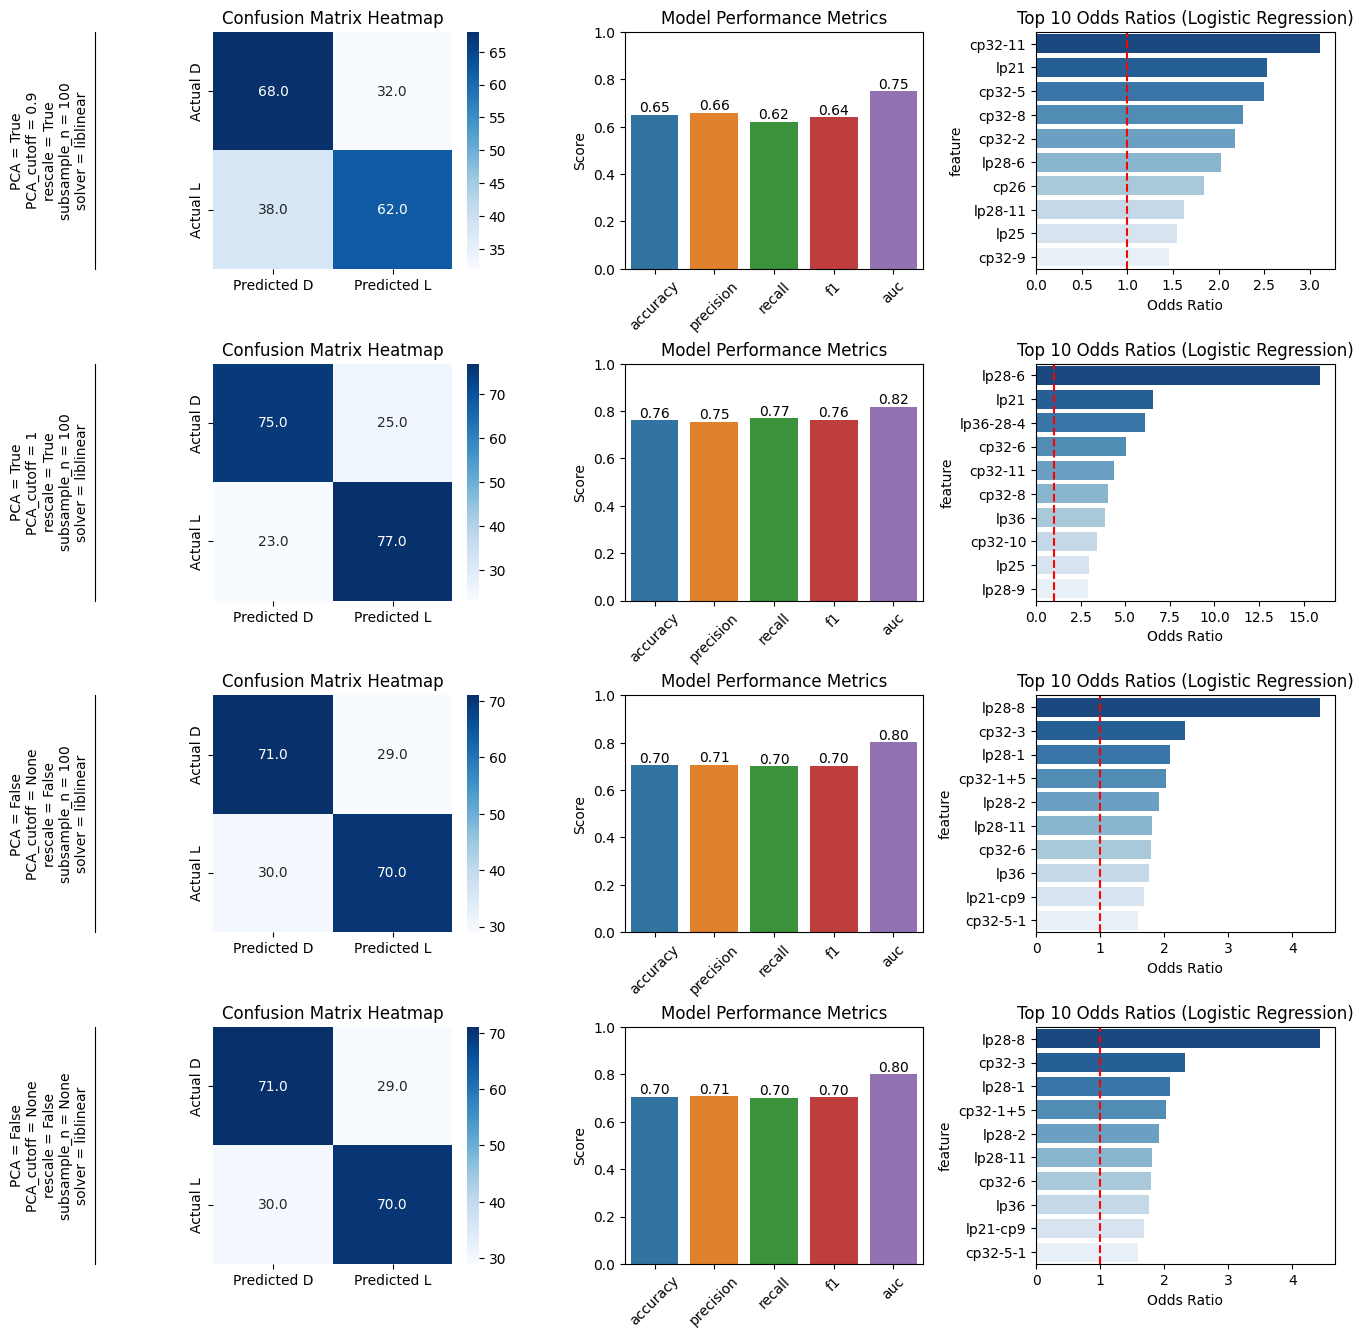

In [20]:
configs = [
    {'PCA': True,  'PCA_cutoff': 0.9,  'rescale': True,  'subsample_n':100,  'solver':'liblinear'},
    {'PCA': True,  'PCA_cutoff': 1,    'rescale': True,  'subsample_n':100,  'solver':'liblinear'},
    {'PCA': False, 'PCA_cutoff': None, 'rescale': False,  'subsample_n':100,  'solver':'liblinear'},
    {'PCA': False, 'PCA_cutoff': None, 'rescale': False, 'subsample_n':None, 'solver':'liblinear'},
]

n_rows = len(configs)
fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows), gridspec_kw={'width_ratios': [0.1, 5, 5, 5]})
fig.subplots_adjust(wspace=0.5, hspace=0.4)

axes = [axes] if n_rows == 1 else axes

fit_df = pd.DataFrame()
for i, config in enumerate(configs):
    kwargs = config

    metrics, odds_ratios, cm, betas, model = fit_model(X_scaf, Y, **kwargs)

    # Plot
    plot_result(axes[i][1:], metrics, odds_ratios, cm, model)

    # Label column
    label = '\n'.join([f"{k} = {v}" for k, v in config.items()])
    axes[i][0].set_ylabel(label)
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][0].spines[['top', 'right', 'bottom']].set_visible(False)

    # Save results in df
    or_df = replicons_ordered.copy()
    or_df['log odds ratio'] = odds_ratios
    or_df['config'] = label
    for k, v in config.items():
        or_df[k] = v
    fit_df = pd.concat([fit_df, or_df], axis=0).reset_index(drop=True)

Performing PCA...
Performing PCA cutoff...
	41 components are being used
Scaling...
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

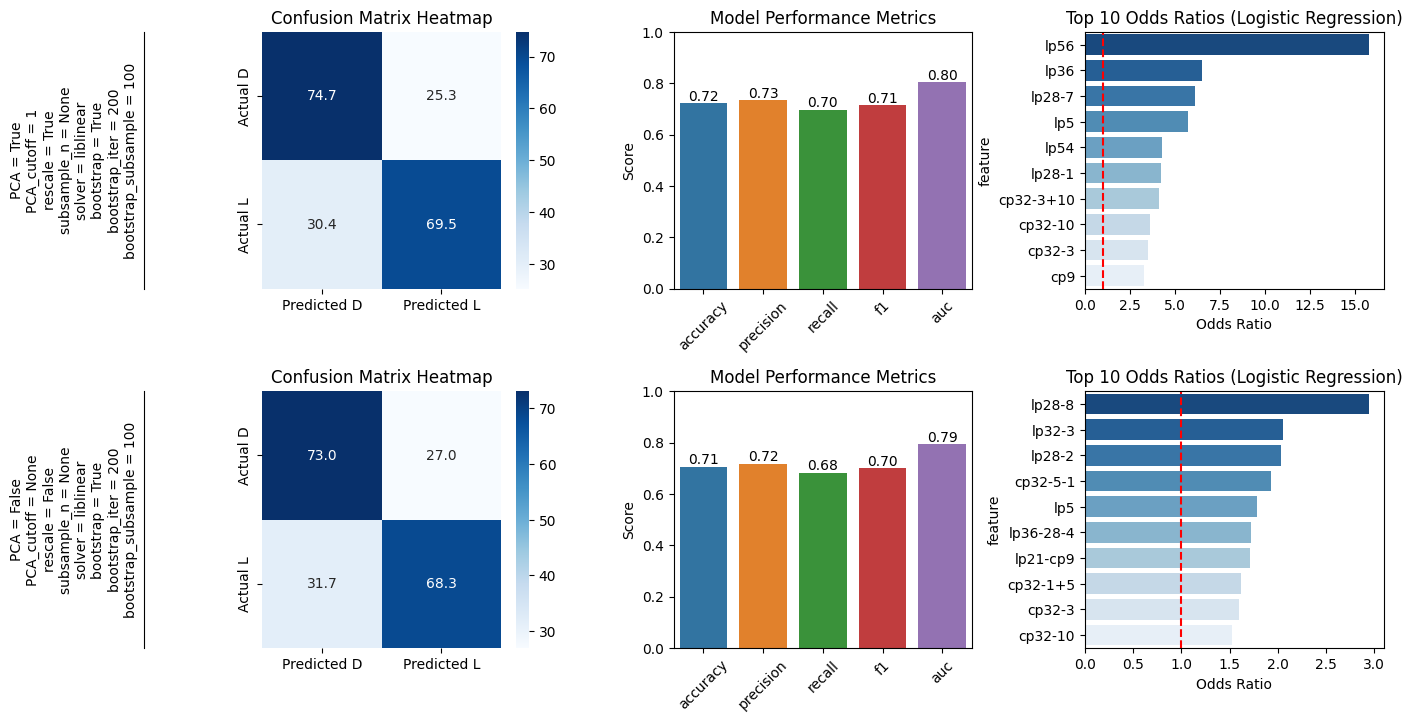

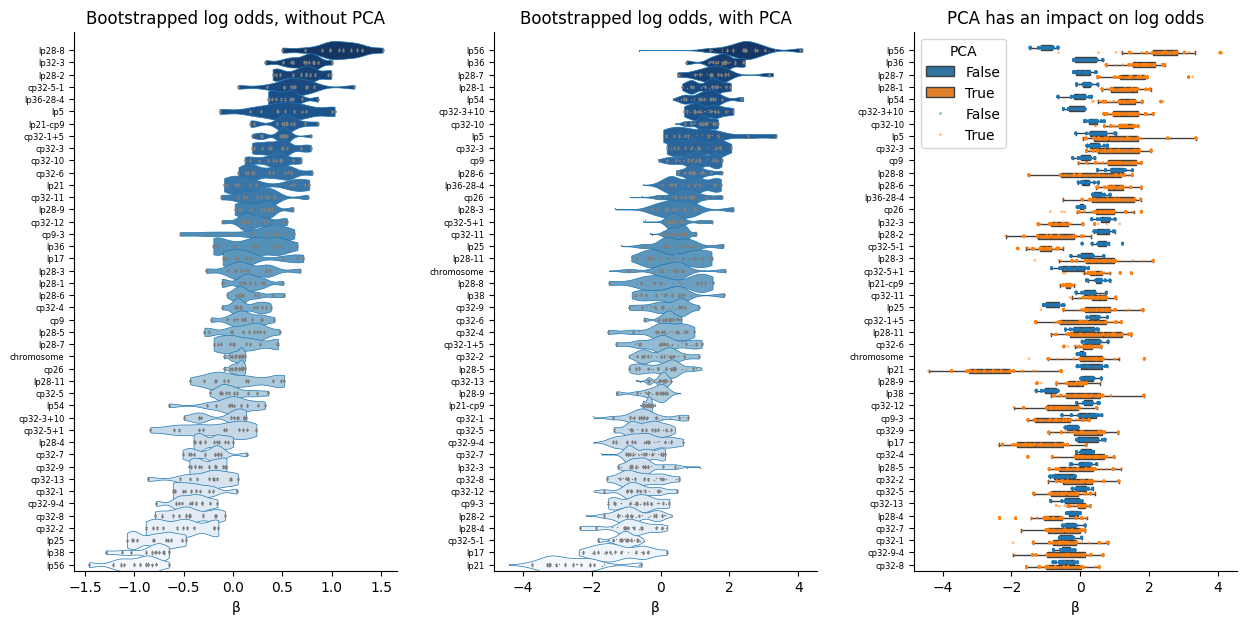

In [21]:
# Prepare data
dissemination_encoder = LabelEncoder()
replicon_key = replicons_ordered['replicon'].tolist()
input_data_df = dissemination_df[dissemination_df['Disseminated'] != 'ND']
# X_SRA = np.stack(input_data_df['SRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
X_model = np.stack(input_data_df['Scaffold replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
# X_LRA = np.stack(input_data_df['LRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
Y_model = dissemination_encoder.fit_transform(input_data_df['Disseminated'].tolist())


configs = [
    # {'PCA': True,  'PCA_cutoff': 0.9,  'rescale': True,  'subsample_n':100,  'solver':'liblinear'},
    # {'PCA': True,  'PCA_cutoff': None, 'rescale': True,  'subsample_n':100,  'solver':'lbfgs'},
    # {'PCA': False, 'PCA_cutoff': None, 'rescale': True,  'subsample_n':100,  'solver':'liblinear'},
    # {'PCA': False, 'PCA_cutoff': None, 'rescale': False, 'subsample_n':None, 'solver':'liblinear'},
    {'PCA': True,  'PCA_cutoff': 1, 'rescale': True,  'subsample_n':None, 'solver':'liblinear', 
         'bootstrap': True, 'bootstrap_iter': 200, 'bootstrap_subsample': 100},
    {'PCA': False,  'PCA_cutoff': None, 'rescale': False, 'subsample_n':None, 'solver':'liblinear', 
         'bootstrap': True, 'bootstrap_iter': 200, 'bootstrap_subsample': 100}
]

n_rows = len(configs)
fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows), gridspec_kw={'width_ratios': [0.1, 5, 5, 5]})
fig.subplots_adjust(wspace=0.5, hspace=0.4)

axes = [axes] if n_rows == 1 else axes
all_betas = []

fit_df = pd.DataFrame()
for i, config in enumerate(configs):
    kwargs = config

    metrics_bootstrap, odds_ratios_bootstrap, cm_bootstrap, betas_bootstrap, models = fit_model(X_model, Y_model, **kwargs)

    cm_avg = np.mean(cm_bootstrap, axis=0)
    metrics_means = {}
    for k,v in metrics_bootstrap.items():
        metrics_means[k] = np.mean(v)
    odds_ratios_mean = np.mean(odds_ratios_bootstrap, axis=0)
    betas_mean = np.mean(betas_bootstrap, axis=0)

    all_betas.append(betas_mean)

    # Plot
    plot_result(axes[i][1:], metrics_means, odds_ratios_mean, cm_avg, betas_mean)
    
    # Label column
    label = '\n'.join([f"{k} = {v}" for k, v in config.items()])
    axes[i][0].set_ylabel(label)
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][0].spines[['top', 'right', 'bottom']].set_visible(False)

    # Save results in df
    results_df = replicons_ordered.copy()
    results_df['beta'] = [beta for beta in betas_bootstrap.transpose(1, 0)]
    results_df['mean(beta)'] = betas_mean
    results_df['config'] = label
    for k, v in config.items():
        results_df[k] = v
    fit_df = pd.concat([fit_df, results_df], axis=0).reset_index(drop=True)

fit_df = fit_df.explode('beta')


fig, axes = plt.subplots(1, 3, figsize=(15,7))
fig.subplots_adjust(wspace=0.3);

ax = axes[0]
ax.set_title('Bootstrapped log odds, without PCA')
sns.violinplot(y='replicon',
               x='beta',
               hue='replicon',
               data=fit_df[fit_df['PCA']==False].sort_values(by='mean(beta)', ascending=False),
               inner=None,
               linecolor='tab:blue',
               palette='Blues_r',
               linewidth=0.5,
               width=1.5,
               cut=0,
               ax=ax);
sns.stripplot(y='replicon',
              x='beta',
              # hue='replicon',
              data=fit_df[fit_df['PCA']==False].sort_values(by='mean(beta)', ascending=False),
              jitter=True,
              color='tab:gray',
              # palette='Blues_r',
              s=1,
              ax=ax);

ax = axes[1]
ax.set_title('Bootstrapped log odds, with PCA')
sns.violinplot(y='replicon',
               x='beta',
               hue='replicon',
               data=fit_df[fit_df['PCA']==True].sort_values(by='mean(beta)', ascending=False),
               inner=None,
               linecolor='tab:blue',
               palette='Blues_r',
               linewidth=0.5,
               width=1.5,
               cut=0,
               ax=ax);
sns.stripplot(y='replicon',
              x='beta',
              # hue='replicon',
              data=fit_df[fit_df['PCA']==True].sort_values(by='mean(beta)', ascending=False),
              jitter=True,
              color='tab:gray',
              # palette='Blues_r',
              s=1,
              ax=ax);

ax = axes[2]
ax.set_title('PCA has an impact on log odds');
sns.boxplot(y='replicon',
            x='beta',
            hue='PCA',
            data=fit_df.sort_values(by='mean(beta)', ascending=False),
            showfliers=False,
            # color='white',
            # palette='Paired',
            ax=ax);
sns.stripplot(y='replicon',
              x='beta',
              hue='PCA',
              dodge=True,
              data=fit_df.sort_values(by='mean(beta)', ascending=False),
              jitter=True,
              s=2,
              # palette='Blues_r',
              alpha=0.5,
              ax=ax);

for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
    ylim = ax.get_ylim(); ax.set_ylim(ylim[0], ylim[1]-1);
    
    yticks = ax.get_yticks(); yticklabels = ax.get_yticklabels();
    ax.set_yticks(yticks); ax.set_yticklabels(yticklabels, fontsize=6);

    ax.set_xlabel('β');
    ax.set_ylabel('');

In [ ]:
# Prepare data
dissemination_encoder = LabelEncoder()
replicon_key = replicons_ordered['replicon'].tolist()
input_data_df = dissemination_df[dissemination_df['Disseminated'] != 'ND']
# X_SRA = np.stack(input_data_df['SRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
X_model = np.stack(input_data_df['Scaffold replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
# X_LRA = np.stack(input_data_df['LRA replicons'].apply(lambda x: replist_to_array(x, replicon_key)).tolist())
Y_model = dissemination_encoder.fit_transform(input_data_df['Disseminated'].tolist())



### PARAM SWEEP
# PCA (True / False)
# PCA cutoff (low, mid, high)
# PCA rescale
# Solver

def param_sweep(var, vals, **kwargs):
    fig, axes = plt.subplots(1, len(vals)+1, figsize=((len(vals)+1)*4, 4))
    fit_df = pd.DataFrame()
    for i, val in enumerate(vals):
        config = {var:val, 'bootstrap':True, 'bootstrap_iter':200, 'bootstrap_subsample':100}
        for k, v in config.items():
            kwargs = dict() if not kwargs else kwargs
            kwargs[k] = v
        metrics_bootstrap, odds_ratios_bootstrap, cm_bootstrap, betas_bootstrap, models = fit_model(X_model, Y_model, **kwargs)
    
        cm_avg = np.mean(cm_bootstrap, axis=0)
        metrics_means = {}
        for k,v in metrics_bootstrap.items():
            metrics_means[k] = np.mean(v)
        odds_ratios_mean = np.mean(odds_ratios_bootstrap, axis=0)
        betas_mean = np.mean(betas_bootstrap, axis=0)
        # Plot cm
        ax = axes[i]
        sns.heatmap(cm_avg, annot=True, fmt='.1f', cmap='Blues', ax=ax)
        ax.set_title(f"{var}={val}\nConfusion Matrix Heatmap");
        # Save results in df
        results_df = replicons_ordered.copy()
        results_df['beta'] = [beta for beta in betas_bootstrap.transpose(1, 0)]
        results_df['mean(beta)'] = betas_mean
        results_df[var] = val
        fit_df = pd.concat([fit_df, results_df], axis=0).reset_index(drop=True)
    fit_df = fit_df.explode('beta')
    ax = axes[-1]
    rep_order = (fit_df[fit_df[var] == vals[0]][['replicon', 'mean(beta)']].drop_duplicates().sort_values('mean(beta)', ascending=False)['replicon'].tolist())
    fit_df['replicon'] = pd.Categorical(fit_df['replicon'], categories=rep_order, ordered=True)
    sns.lineplot(y='replicon',
                 x='mean(beta)',
                 hue=var,
                 data=fit_df.sort_values('replicon'),
                 sort=False,
                 ax=ax);
    sns.stripplot(y='replicon',
                  x='beta',
                  hue=var,
                  data=fit_df,
                  jitter=True,
                  s=2,
                  alpha=0.5,
                  ax=ax)
    ax.set_title(var);
    ax.set_yticks(ax.get_yticks());
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=5);
    ax.legend(bbox_to_anchor=(1,1));
    fig.tight_layout();
    return fig, axes, fit_df

# PCA (True / False)
var = 'PCA'
vals = [False, True]
fig, axes, fit_df_pca = param_sweep(var, vals)

# PCA_cutoff (low, mid, high)
var = 'PCA_cutoff'
vals = [1, 0.85, 0.7]
fig, axes, fit_df_pca = param_sweep(var, vals, PCA=True)

# PCA rescale
var = 'rescale'
vals = [True, False]
fig, axes, fit_df_pca = param_sweep(var, vals, PCA=True)

# Solver
var = 'solver'
vals = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
fig, axes, fit_df_pca = param_sweep(var, vals)

Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Performing PCA cutoff...
	41 components are being used
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Performing PCA cutoff...
	21 components are being used
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Performing PCA cutoff...
	14 components are being used
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Scaling...
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Performing PCA...
Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Bootstrapping...


/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/mf019/Bb_pangenome/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov